In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AF_Stock_TW_1301.TW.csv to AF_Stock_TW_1301.TW.csv


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time

In [ ]:
df = pd.read_csv('AF_Stock_TW_1301.TW.csv')

In [ ]:
df

,open,high,low,close,volume,ht_dcperiod,ht_dcphase,inphase,quadrature,sine,leadsine,ht_trendmode,add,div,max_x,maxindex,min_x,minindex,min_y,max_y,minidx,maxidx,mult,sub,sum,acos,asin,atan,ceil,cos,cosh,exp,floor,ln,log10,sin,sinh,sqrt,tan,tanh,...,cdlstalledpattern,cdlsticksandwich,cdltakuri,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods,avgprice,medprice,typprice,wclprice,beta,correl,linearreg,linearreg_angle,linearreg_intercept,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv,year,month,day,weekofyear,dayofyear,dayofweek,bias,ama,psy,dpo,vhf,rvi
0,60.823046,60.885493,60.261025,60.573261,6164080.0,NaN,NaN,NaN,NaN,NaN,NaN,0,121.146518,1.010363,NaN,0,NaN,0,NaN,NaN,0,0,3669.022190,0.624468,NaN,NaN,NaN,1.554289,61.0,-0.634835,1.012985e+26,2.025970e+26,60.0,4.103854,1.782281,-0.772647,1.012985e+26,7.782883,1.217083,1.0,...,0,0,0,0,0,0,0,0,0,60.635706,60.573259,60.573260,60.573260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.890924e+01,NaN,6164080.0,2011,1,3,1,3,1,NaN,NaN,NaN,NaN,NaN,NaN
1,60.573261,60.573261,60.011240,60.385918,7222800.0,NaN,NaN,NaN,NaN,NaN,NaN,0,120.584501,1.009365,NaN,0,NaN,0,NaN,NaN,0,0,3635.076530,0.562021,NaN,NaN,NaN,1.554238,61.0,-0.767633,8.399256e+25,1.679851e+26,60.0,4.100756,1.780936,-0.640890,8.399256e+25,7.770838,0.834892,1.0,...,0,0,0,0,0,0,0,0,0,60.385920,60.292251,60.323473,60.339084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.562021,2.407564e+06,NaN,-1058720.0,2011,1,4,1,4,2,NaN,NaN,NaN,NaN,NaN,NaN
2,60.323460,60.323460,59.012084,59.761444,10587200.0,NaN,NaN,NaN,NaN,NaN,NaN,0,119.335544,1.022222,NaN,0,NaN,0,NaN,NaN,0,0,3559.813114,1.311377,NaN,NaN,NaN,1.554065,60.0,-0.997468,4.498165e+25,8.996330e+25,59.0,4.090361,1.776421,-0.071124,4.498165e+25,7.730553,0.071304,1.0,...,0,0,0,0,0,0,0,0,0,59.855112,59.667772,59.698996,59.714608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.373834,3.920055e+06,NaN,-11645920.0,2011,1,5,1,5,3,NaN,NaN,NaN,NaN,NaN,NaN
3,59.823893,59.948786,58.887189,59.386765,11271520.0,NaN,NaN,NaN,NaN,NaN,NaN,0,118.835975,1.018028,NaN,0,NaN,0,NaN,NaN,0,0,3530.215511,1.061597,NaN,NaN,NaN,1.553959,60.0,-0.954298,3.092532e+25,6.185063e+25,59.0,4.084071,1.773690,0.298858,3.092532e+25,7.706281,-0.313171,1.0,...,0,0,0,0,0,0,0,0,0,59.511658,59.417988,59.407580,59.402376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.061597,3.257031e+06,NaN,-22917440.0,2011,1,6,1,6,4,NaN,NaN,NaN,NaN,NaN,NaN
4,58.762292,59.012082,57.013787,57.326023,15686320.0,NaN,NaN,NaN,NaN,NaN,NaN,0,116.025869,1.035049,NaN,0,NaN,0,NaN,NaN,0,0,3364.502273,1.998295,NaN,NaN,NaN,1.553354,58.0,0.712771,3.938633e+24,7.877266e+24,57.0,4.048755,1.758352,0.701397,3.938633e+24,7.571395,0.984042,1.0,...,0,0,0,0,0,0,0,0,0,58.028546,58.012934,57.783964,57.669479,NaN,NaN,NaN,NaN,NaN,NaN,1.161310,NaN,1.348641,NaN,NaN,2.372978,-7.527273e+06,NaN,-38603760.0,2011,1,7,1,7,5,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2561,103.500000,104.000000,102.000000,103.000000,3044218.0,22.051860,276.228972,-0.820773,-2.885485,-0.994096,-0.626210,0,206.000000,1.019608,106.5,2549,93.400002,2534,93.400002,106.5,2534,2549,10608.000000,2.000000,3049.400009,NaN,NaN,1.561088,103.0,-0.782231,2.699614e+44,5.399228e+44,103.0,4.634729,2.012837,0.622989,2.699614e+44,10.148892,-0.796426,1.0,...,0,0,0,0,0,0,0,0,0,103.125000,103.000000,103.000000,103.000000,1.003425,0.969682,101.814286,-15.712284,105.471429,-0.281319,1.200000,101.532967,1.440000,2.562436,2.487802,2.000000,1.454445e+09,1.050045e+06,588320317.0,2021,6,24,25,175,4,-0.005792,0.422,50.000000,-0.136364,0.326683,0.135837
2562,102.500000,105.000000,102.500000,104.000000,7467282.0,22.057605,293.669204,-2.031413,-2.632432,-0.915879,-0.363752,0,207.

In [ ]:
# 保留前 100 row 空值小於等於 60% 的 column
df = df[df.columns[df.iloc[:101,:].isnull().sum()/100 <= 0.6]]

In [ ]:
df

,open,high,low,close,volume,ht_dcperiod,inphase,quadrature,ht_trendmode,add,div,max_x,maxindex,min_x,minindex,min_y,max_y,minidx,maxidx,mult,sub,sum,atan,ceil,cos,cosh,exp,floor,ln,log10,sin,sinh,sqrt,tan,tanh,adx,adxr,apo,aroondown,aroonup,...,cdlstalledpattern,cdlsticksandwich,cdltakuri,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods,avgprice,medprice,typprice,wclprice,beta,correl,linearreg,linearreg_angle,linearreg_intercept,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv,year,month,day,weekofyear,dayofyear,dayofweek,bias,ama,psy,dpo,vhf,rvi
0,65.568988,66.817919,65.256752,66.193451,16364400.0,21.675377,-0.084339,1.179410,0,132.074670,1.023923,66.193451,58,57.575813,41,57.575813,66.193451,41,58,4360.320336,1.561167,1863.720329,1.555690,67.0,-0.975896,2.795249e+28,5.590498e+28,66.0,4.192582,1.820815,-0.218235,2.795249e+28,8.135936,0.223625,1.0,16.777579,17.983408,1.793738,0.000000,100.000000,...,0,0,0,0,0,0,0,0,0,65.959277,66.037335,66.089374,66.115393,0.744557,0.938352,65.408405,16.909188,61.456426,0.303998,0.642930,65.712404,0.413358,1.781153,2.690830,1.873407,7.059280e+07,1.226457e+07,101533120.0,2011,4,6,14,96,3,0.062710,1.331361,50.000000,2.299174,0.348485,0.053824
1,66.817919,67.130155,64.007821,66.193451,17040400.0,21.813179,0.808491,2.935545,0,131.137976,1.048780,66.193451,59,57.575813,41,57.575813,66.193451,41,59,4296.854971,3.122333,1864.344795,1.555690,67.0,-0.975896,2.795249e+28,5.590498e+28,66.0,4.192582,1.820815,-0.218235,2.795249e+28,8.135936,0.223625,1.0,16.550714,17.562460,2.001894,0.000000,100.000000,...,0,0,0,0,0,0,0,0,0,66.037336,65.568988,65.777142,65.881220,1.084252,0.934892,65.816987,17.397413,61.743678,0.313331,0.642928,66.130318,0.413356,1.876952,2.835555,3.122333,7.740892e+07,1.368435e+07,101533120.0,2011,4,7,14,97,4,0.057779,1.562289,50.000000,2.043710,0.389831,0.035007
2,66.193459,66.193459,64.944528,65.256760,9403680.0,22.217000,2.162174,1.898309,0,131.137987,1.019231,66.193451,59,57.575813,41,57.575813,66.193451,41,59,4298.902955,1.248931,1865.281509,1.555473,66.0,-0.753987,1.095521e+28,2.191042e+28,65.0,4.178330,1.814626,0.656890,1.095521e+28,8.078166,-0.871222,1.0,16.340054,16.971867,2.035520,0.000000,92.857143,...,0,0,0,0,0,0,0,0,0,65.647051,65.568994,65.464916,65.412877,0.395521,0.937028,65.952588,16.656946,62.063046,0.299195,0.642928,66.251783,0.413356,1.832093,2.807515,1.248931,7.270706e+07,1.152509e+07,92129440.0,2011,4,8,14,98,5,0.037839,1.763492,45.833333,0.879939,0.379121,0.016787
3,65.568985,65.568985,64.944517,65.568985,5519280.0,22.792088,2.033302,-0.532854,0,130.513502,1.009615,66.193451,59,57.575813,41,57.575813,66.193451,41,59,4258.346082,0.624468,1869.153198,1.555546,66.0,-0.919315,1.496988e+28,2.993976e+28,65.0,4.183103,1.816698,0.393523,1.496988e+28,8.097468,-0.428061,1.0,16.144433,16.737947,2.024712,0.000000,85.714286,...,0,0,100,0,0,0,0,0,0,65.412868,65.256751,65.360829,65.412868,0.374470,0.938903,66.041797,15.202795,62.509095,0.271746,0.499574,66.313544,0.249574,1.745834,2.662591,0.624468,7.822634e+07,1.135015e+07,97648720.0,2011,4,11,15,101,1,0.036218,1.933846,45.833333,0.993470,0.376022,-0.016290
4,65.568979,65.568979,63.695576,64.944511,12793040.0,23.401725,1.481944,-0.619500,0,129.264555,1.029412,66.193451,59,57.575813,41,57.575813,66.193451,41,59,4176.453900,1.873403,1872.088184,1.555400,65.0,-0.515732,8.017020e+27,1.603404e+28,64.0,4.173533,1.812542,0.856750,8.017020e+27,8.058816,-1.661230,1.0,15.080424,16.079555,1.945853,0.000000,78.571429,...,0,0,0,0,0,0,0,0,0,64.944511,64.632278,64.736356,64.788395,0.489814,0.941230,66.086400,14.652149,62.687515,0.261453,0.499574,66.347853,0.249574,1.754947,2.702225,1.873409,8.249069e+07,1.160359e+07,84855680.0,2011,4,12,15,102,2,0.020709,2.074851,45.833333,0.170303,0.367021,0.028569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
# 刪除前 58 row 當新的 df
df.drop([x for x in range(58)], axis='index', inplace=True)

In [ ]:
df

,open,high,low,close,volume,ht_dcperiod,inphase,quadrature,ht_trendmode,add,div,max_x,maxindex,min_x,minindex,min_y,max_y,minidx,maxidx,mult,sub,sum,atan,ceil,cos,cosh,exp,floor,ln,log10,sin,sinh,sqrt,tan,tanh,adx,adxr,apo,aroondown,aroonup,...,cdlstalledpattern,cdlsticksandwich,cdltakuri,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods,avgprice,medprice,typprice,wclprice,beta,correl,linearreg,linearreg_angle,linearreg_intercept,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv,year,month,day,weekofyear,dayofyear,dayofweek,bias,ama,psy,dpo,vhf,rvi
58,61.509949,62.758879,61.135266,62.446648,12807600.0,16.549789,-3.530233,-1.914047,1,123.894145,1.026558,72.438110,87,59.761444,114,59.761444,72.438110,114,87,3836.780769,1.623613,2037.384472,1.554784,63.0,0.926721,6.594843e+26,1.318969e+27,62.0,4.134313,1.795509,-0.375750,6.594843e+26,7.902319,-0.405461,1.0,32.812198,25.999471,-3.095514,85.714286,7.142857,...,0,0,0,0,0,0,0,0,0,61.962685,61.947073,62.113598,62.196860,1.066887,0.979817,60.161104,-34.282177,69.023178,-0.681698,0.949025,59.479406,0.900648,1.942428,3.110539,2.185618,1.769308e+08,-6.018217e+06,52811200.0,2011,6,29,26,180,3,-0.060195,-2.833953,29.166667,-1.481693,0.422038,-0.090339
59,62.446652,64.944517,62.446652,64.632286,15118480.0,17.875951,-3.907167,-0.705000,1,127.391169,1.040000,72.438110,90,59.761444,114,59.761444,72.438110,114,90,4055.567663,2.497866,2029.578648,1.555325,65.0,-0.227624,5.866988e+27,1.173398e+28,64.0,4.168714,1.810450,0.973749,5.866988e+27,8.039421,-4.277889,1.0,31.652944,26.474051,-3.013453,78.571429,0.000000,...,0,0,0,0,0,0,0,0,0,63.617527,63.695585,64.007818,64.163935,0.942593,0.979845,60.667816,-29.509848,68.025812,-0.566000,1.795426,60.101816,3.223553,1.982102,3.066737,2.497870,1.882697e+08,-5.473645e+04,67929680.0,2011,6,30,26,181,4,-0.022709,-3.399845,33.333333,1.101333,0.401186,-0.103546
60,64.632289,66.193451,64.007821,66.193451,10553920.0,19.443238,-4.043347,1.374713,1,130.201272,1.034146,72.438110,90,59.761444,114,59.761444,72.438110,114,90,4236.898589,2.185629,2023.646214,1.555690,67.0,-0.975896,2.795249e+28,5.590498e+28,66.0,4.192582,1.820815,-0.218235,2.795249e+28,8.135936,0.223625,1.0,29.942424,26.597698,-3.079501,71.428571,14.285714,...,0,0,0,0,0,0,0,0,0,65.256753,65.100636,65.464908,65.647044,1.210241,0.979191,61.406471,-24.340118,67.287157,-0.452361,2.414869,60.954110,5.831590,1.996640,3.016370,2.185629,1.988236e+08,5.747911e+06,78483600.0,2011,7,1,26,182,5,0.004454,-3.945753,37.500000,2.861191,0.374032,-0.039795
61,66.505676,67.754606,66.193440,67.442375,13400400.0,20.243293,-3.363298,4.599632,1,133.948047,1.023585,72.438110,90,59.761444,114,59.761444,72.438110,114,90,4484.910481,1.561166,2019.587185,1.555970,68.0,-0.101691,9.745887e+28,1.949177e+29,67.0,4.211274,1.828933,-0.994816,9.745887e+28,8.212331,9.782755,1.0,27.968520,25.510468,-3.037470,64.285714,7.142857,...,-100,0,0,0,0,0,0,0,0,66.974024,66.974023,67.130141,67.208199,-0.660769,0.978040,62.555487,-15.772385,66.227350,-0.282451,2.485341,62.273036,6.176920,1.965534,2.914391,1.561166,2.068639e+08,1.015745e+07,91884000.0,2011,7,4,27,185,1,0.026811,-4.415477,41.666667,4.138502,0.370442,0.037799
62,67.442374,69.315771,66.505675,69.003540,16332160.0,20.357399,-1.726245,7.412469,1,135.821446,1.042253,71.813652,99,59.761444,114,59.761444,71.813652,114,99,4609.892142,2.810097,2016.152615,1.556305,70.0,0.993790,4.643299e+29,9.286599e+29,69.0,4.234158,1.838871,-0.111267,4.643299e+29,8.306837,-0.111963,1.0,26.770680,24.889304,-2.873348,57.142857,0.000000,...,0,0,0,0,0,0,0,0,0,68.066840,67.910723,68.274995,68.457132,-0.021520,0.976006,64.400336,0.078604,64.382501,0.001372,2.263634,64.401707,5.124041,2.025860,2.935879,2.810097,2.195667e+08,1.507975e+07,108216160.0,2011,7,5,27,186,2,0.052080,-4.772172,41.666667,5.444204,0.363466,0.162394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [ ]:
# index reset
df.reset_index(drop=True, inplace=True)

In [ ]:
df

,open,high,low,close,volume,ht_dcperiod,inphase,quadrature,ht_trendmode,add,div,max_x,maxindex,min_x,minindex,min_y,max_y,minidx,maxidx,mult,sub,sum,atan,ceil,cos,cosh,exp,floor,ln,log10,sin,sinh,sqrt,tan,tanh,adx,adxr,apo,aroondown,aroonup,...,cdlstalledpattern,cdlsticksandwich,cdltakuri,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods,avgprice,medprice,typprice,wclprice,beta,correl,linearreg,linearreg_angle,linearreg_intercept,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv,year,month,day,weekofyear,dayofyear,dayofweek,bias,ama,psy,dpo,vhf,rvi
0,61.509949,62.758879,61.135266,62.446648,12807600.0,16.549789,-3.530233,-1.914047,1,123.894145,1.026558,72.438110,87,59.761444,114,59.761444,72.438110,114,87,3836.780769,1.623613,2037.384472,1.554784,63.0,0.926721,6.594843e+26,1.318969e+27,62.0,4.134313,1.795509,-0.375750,6.594843e+26,7.902319,-0.405461,1.0,32.812198,25.999471,-3.095514,85.714286,7.142857,...,0,0,0,0,0,0,0,0,0,61.962685,61.947073,62.113598,62.196860,1.066887,0.979817,60.161104,-34.282177,69.023178,-0.681698,0.949025,59.479406,0.900648,1.942428,3.110539,2.185618,1.769308e+08,-6.018217e+06,52811200.0,2011,6,29,26,180,3,-0.060195,-2.833953,29.166667,-1.481693,0.422038,-0.090339
1,62.446652,64.944517,62.446652,64.632286,15118480.0,17.875951,-3.907167,-0.705000,1,127.391169,1.040000,72.438110,90,59.761444,114,59.761444,72.438110,114,90,4055.567663,2.497866,2029.578648,1.555325,65.0,-0.227624,5.866988e+27,1.173398e+28,64.0,4.168714,1.810450,0.973749,5.866988e+27,8.039421,-4.277889,1.0,31.652944,26.474051,-3.013453,78.571429,0.000000,...,0,0,0,0,0,0,0,0,0,63.617527,63.695585,64.007818,64.163935,0.942593,0.979845,60.667816,-29.509848,68.025812,-0.566000,1.795426,60.101816,3.223553,1.982102,3.066737,2.497870,1.882697e+08,-5.473645e+04,67929680.0,2011,6,30,26,181,4,-0.022709,-3.399845,33.333333,1.101333,0.401186,-0.103546
2,64.632289,66.193451,64.007821,66.193451,10553920.0,19.443238,-4.043347,1.374713,1,130.201272,1.034146,72.438110,90,59.761444,114,59.761444,72.438110,114,90,4236.898589,2.185629,2023.646214,1.555690,67.0,-0.975896,2.795249e+28,5.590498e+28,66.0,4.192582,1.820815,-0.218235,2.795249e+28,8.135936,0.223625,1.0,29.942424,26.597698,-3.079501,71.428571,14.285714,...,0,0,0,0,0,0,0,0,0,65.256753,65.100636,65.464908,65.647044,1.210241,0.979191,61.406471,-24.340118,67.287157,-0.452361,2.414869,60.954110,5.831590,1.996640,3.016370,2.185629,1.988236e+08,5.747911e+06,78483600.0,2011,7,1,26,182,5,0.004454,-3.945753,37.500000,2.861191,0.374032,-0.039795
3,66.505676,67.754606,66.193440,67.442375,13400400.0,20.243293,-3.363298,4.599632,1,133.948047,1.023585,72.438110,90,59.761444,114,59.761444,72.438110,114,90,4484.910481,1.561166,2019.587185,1.555970,68.0,-0.101691,9.745887e+28,1.949177e+29,67.0,4.211274,1.828933,-0.994816,9.745887e+28,8.212331,9.782755,1.0,27.968520,25.510468,-3.037470,64.285714,7.142857,...,-100,0,0,0,0,0,0,0,0,66.974024,66.974023,67.130141,67.208199,-0.660769,0.978040,62.555487,-15.772385,66.227350,-0.282451,2.485341,62.273036,6.176920,1.965534,2.914391,1.561166,2.068639e+08,1.015745e+07,91884000.0,2011,7,4,27,185,1,0.026811,-4.415477,41.666667,4.138502,0.370442,0.037799
4,67.442374,69.315771,66.505675,69.003540,16332160.0,20.357399,-1.726245,7.412469,1,135.821446,1.042253,71.813652,99,59.761444,114,59.761444,71.813652,114,99,4609.892142,2.810097,2016.152615,1.556305,70.0,0.993790,4.643299e+29,9.286599e+29,69.0,4.234158,1.838871,-0.111267,4.643299e+29,8.306837,-0.111963,1.0,26.770680,24.889304,-2.873348,57.142857,0.000000,...,0,0,0,0,0,0,0,0,0,68.066840,67.910723,68.274995,68.457132,-0.021520,0.976006,64.400336,0.078604,64.382501,0.001372,2.263634,64.401707,5.124041,2.025860,2.935879,2.810097,2.195667e+08,1.507975e+07,108216160.0,2011,7,5,27,186,2,0.052080,-4.772172,41.666667,5.444204,0.363466,0.162394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
def allprocessLSTM(df, lookback, input_dim, output_dim, num_epochs):

  # plt.figure(figsize=(16, 12))
  # plt.plot(df['Close'])
  # plt.show()

  scaler = MinMaxScaler()
  scaler_data = scaler.fit_transform(df.values)

  def split_data(stock, lookback):
    # data_raw = stock.to_numpy() # convert to numpy array
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback,:])
    
    data = np.array(data);

    # print(data)
    # print(data.shape)

    # test_set_size = int(np.round(0.2*data.shape[0]));
    test_set_size = 120
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,3:4]
    
    x_test = data[train_set_size:,:-1,:]
    y_test = data[train_set_size:,-1,3:4]
    
    return [x_train, y_train, x_test, y_test]

  x_train, y_train, x_test, y_test = split_data(scaler_data, lookback)

  x_train = torch.from_numpy(x_train).type(torch.Tensor)
  x_test = torch.from_numpy(x_test).type(torch.Tensor)
  y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
  y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
  y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
  y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

  input_dim = input_dim
  hidden_dim = 32
  num_layers = 2
  output_dim = output_dim
  num_epochs = num_epochs

  class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

  model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
  criterion = torch.nn.MSELoss(reduction='mean')
  optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

  hist = np.zeros(num_epochs+1)
  start_time = time.time()
  lstm = []

  for t in range(num_epochs+1):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    if t%10 == 0:
      print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

  training_time = time.time()-start_time
  print("Training time: {}".format(training_time))

  y_test_pred = model(x_test)

  return y_test_pred, y_test

In [ ]:
def allprocessGRU(df, lookback, input_dim, output_dim, num_epochs):

  # plt.figure(figsize=(16, 12))
  # plt.plot(df['Close'])
  # plt.show()

  scaler = MinMaxScaler()
  scaler_data = scaler.fit_transform(df.values)

  def split_data(stock, lookback):
    # data_raw = stock.to_numpy() # convert to numpy array
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback,:])
    
    data = np.array(data);

    # print(data)
    # print(data.shape)

    # test_set_size = int(np.round(0.2*data.shape[0]));
    test_set_size = 120
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,3:4]
    
    x_test = data[train_set_size:,:-1,:]
    y_test = data[train_set_size:,-1,3:4]
    
    return [x_train, y_train, x_test, y_test]

  x_train, y_train, x_test, y_test = split_data(scaler_data, lookback)

  x_train = torch.from_numpy(x_train).type(torch.Tensor)
  x_test = torch.from_numpy(x_test).type(torch.Tensor)
  y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
  y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
  y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
  y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

  input_dim = input_dim
  hidden_dim = 32
  num_layers = 2
  output_dim = output_dim
  num_epochs = num_epochs

  class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

  model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
  criterion = torch.nn.MSELoss(reduction='mean')
  optimiser = torch.optim.Adam(model.parameters(), lr=0.01)     

  hist = np.zeros(num_epochs+1)
  start_time = time.time()
  gru = []

  for t in range(num_epochs+1):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_gru)
    if t%10 == 0:
      print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

  training_time = time.time()-start_time
  print("Training time: {}".format(training_time))

  y_test_pred = model(x_test)

  return y_test_pred, y_test

In [ ]:
y_pred_base10y_LSTM, y_test = allprocessLSTM(df, 20, 183, 1, 100)
# y_pred_base10y_GRU, y_test = allprocessGRU(df, 20, 5, 1, 500)

Epoch  0 MSE:  0.22285394370555878
Epoch  10 MSE:  0.03139340505003929
Epoch  20 MSE:  0.0031875174026936293
Epoch  30 MSE:  0.0012660768115893006
Epoch  40 MSE:  0.0010361650492995977
Epoch  50 MSE:  0.0006285039708018303
Epoch  60 MSE:  0.0004870112461503595
Epoch  70 MSE:  0.00040315574733540416
Epoch  80 MSE:  0.00036241518682800233
Epoch  90 MSE:  0.00032962573459371924
Epoch  100 MSE:  0.00030524132307618856
Training time: 37.03404951095581


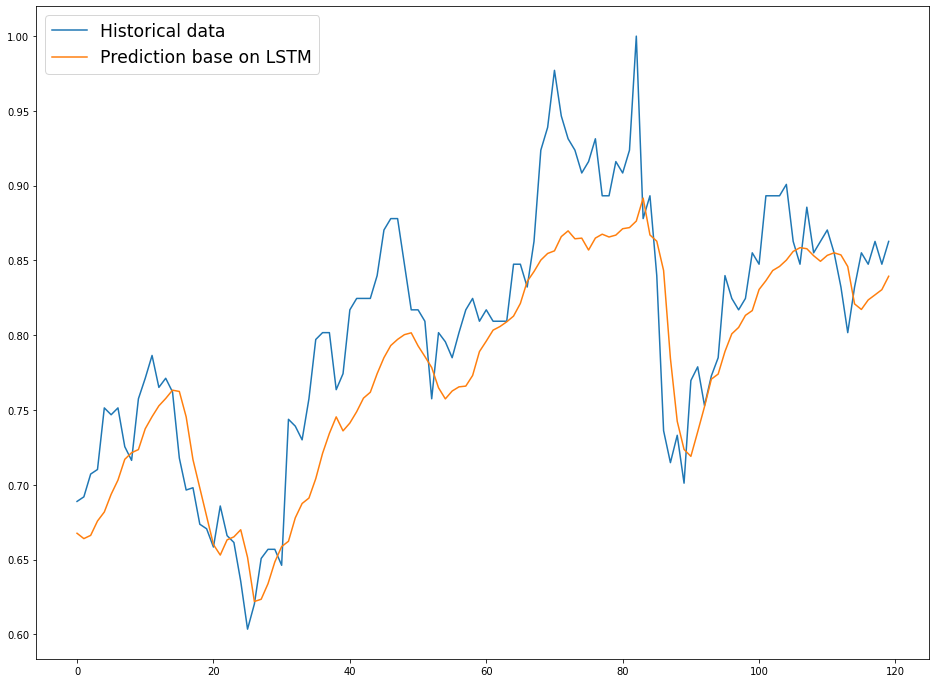

In [ ]:
plt.figure(figsize=(16, 12))

plt.plot(y_test, label='Historical data')
plt.plot(y_pred_base10y_LSTM.detach().numpy(), label='Prediction base on LSTM')
plt.legend(fontsize='xx-large', loc='upper left')

plt.show()

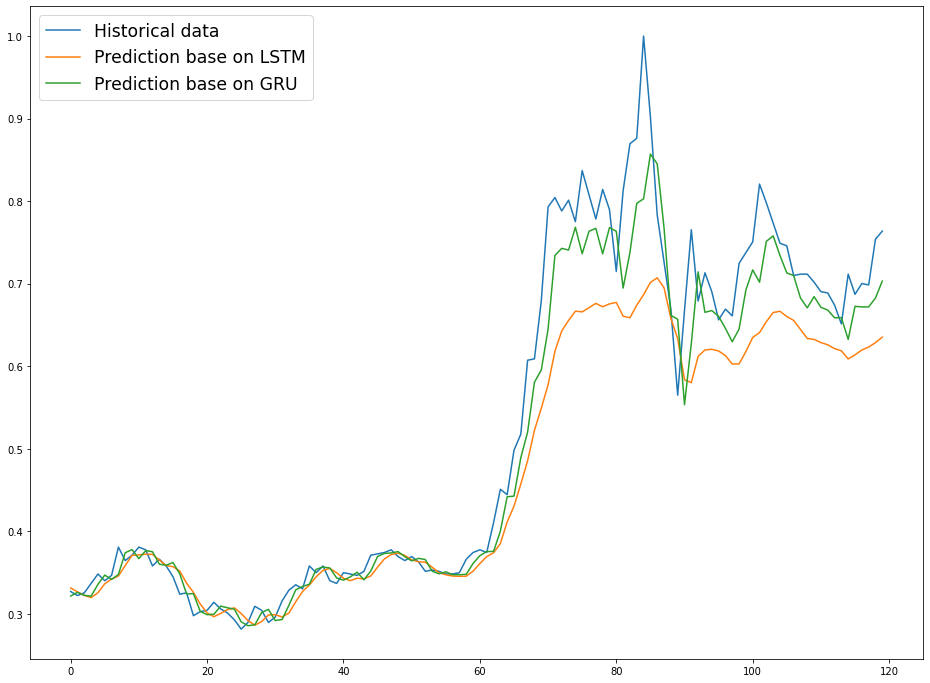

In [ ]:
plt.figure(figsize=(16, 12))

plt.plot(y_test, label='Historical data')
plt.plot(y_pred_base10y_LSTM.detach().numpy(), label='Prediction base on LSTM')
plt.plot(y_pred_base10y_GRU.detach().numpy(), label='Prediction base on GRU')
plt.legend(fontsize='xx-large', loc='upper left')

plt.show()

In [ ]:
df2y = dft[dft['Date'].between('2019-06-30', '2021-06-30')]

In [ ]:
df2y = df2y.drop(['Date', 'Dividends', 'Stock Splits'], axis = 1)

In [ ]:
y_pred_base2y_LSTM, y_test = allprocessLSTM(df2y, 20, 5, 1, 500)
y_pred_base2y_GRU, y_test = allprocessGRU(df2y, 20, 5, 1, 500)

Epoch  0 MSE:  0.03341482952237129
Epoch  10 MSE:  0.003823259612545371
Epoch  20 MSE:  0.00312423356808722
Epoch  30 MSE:  0.0024832861963659525
Epoch  40 MSE:  0.000606555724516511
Epoch  50 MSE:  0.0003618558694142848
Epoch  60 MSE:  0.0002725707017816603
Epoch  70 MSE:  0.00023819976195227355
Epoch  80 MSE:  0.0002064559084828943
Epoch  90 MSE:  0.00018399815598968416
Epoch  100 MSE:  0.00016819153097458184
Epoch  110 MSE:  0.00015522458124905825
Epoch  120 MSE:  0.0001436057355022058
Epoch  130 MSE:  0.0001335591950919479
Epoch  140 MSE:  0.0001254361995961517
Epoch  150 MSE:  0.00011969420302193612
Epoch  160 MSE:  0.00011587596236495301
Epoch  170 MSE:  0.00011298349272692576
Epoch  180 MSE:  0.00011037899821531028
Epoch  190 MSE:  0.00010797179857036099
Epoch  200 MSE:  0.00010578659566817805
Epoch  210 MSE:  0.00010380952880950645
Epoch  220 MSE:  0.00010201361874351278
Epoch  230 MSE:  0.00010037348693003878
Epoch  240 MSE:  9.886507177725434e-05
Epoch  250 MSE:  9.7465330327

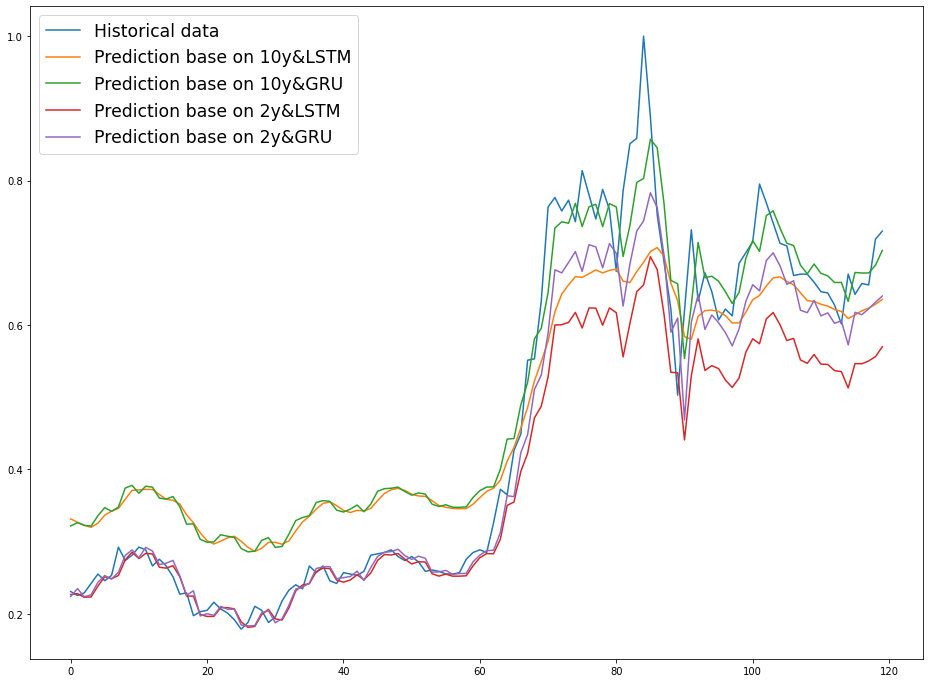

In [ ]:
plt.figure(figsize=(16, 12))

plt.plot(y_test, label='Historical data')
plt.plot(y_pred_base10y_LSTM.detach().numpy(), label='Prediction base on 10y&LSTM')
plt.plot(y_pred_base10y_GRU.detach().numpy(), label='Prediction base on 10y&GRU')
plt.plot(y_pred_base2y_LSTM.detach().numpy(), label='Prediction base on 2y&LSTM')
plt.plot(y_pred_base2y_GRU.detach().numpy(), label='Prediction base on 2y&GRU')
plt.legend(fontsize='xx-large', loc='upper left')

plt.show()

Training for lookback : 3 
Epoch  0 MSE:  0.17703059315681458
Epoch  5 MSE:  0.039846379309892654
Epoch  10 MSE:  0.027244649827480316
Epoch  15 MSE:  0.021308233961462975
Epoch  20 MSE:  0.010438703000545502
Epoch  25 MSE:  0.003445020643994212
Epoch  30 MSE:  0.002414038637652993
Epoch  35 MSE:  0.0010937261395156384
Epoch  40 MSE:  0.0007815959979780018
Epoch  45 MSE:  0.0011855846969410777
Epoch  50 MSE:  0.0009635317837819457
Epoch  55 MSE:  0.0006339937681332231
Epoch  60 MSE:  0.0005946861347183585
Epoch  65 MSE:  0.0005111991777084768
Epoch  70 MSE:  0.00047347325016744435
Epoch  75 MSE:  0.0004780586459673941
Epoch  80 MSE:  0.0004534941981546581
Epoch  85 MSE:  0.00044392223935574293
Epoch  90 MSE:  0.0004318362334743142
Epoch  95 MSE:  0.0004175138019490987
Epoch  100 MSE:  0.0004072527517564595
Epoch  105 MSE:  0.0003948644734919071
Epoch  110 MSE:  0.00038422434590756893
Epoch  115 MSE:  0.0003733714984264225
Epoch  120 MSE:  0.00036293535958975554
Epoch  125 MSE:  0.00035

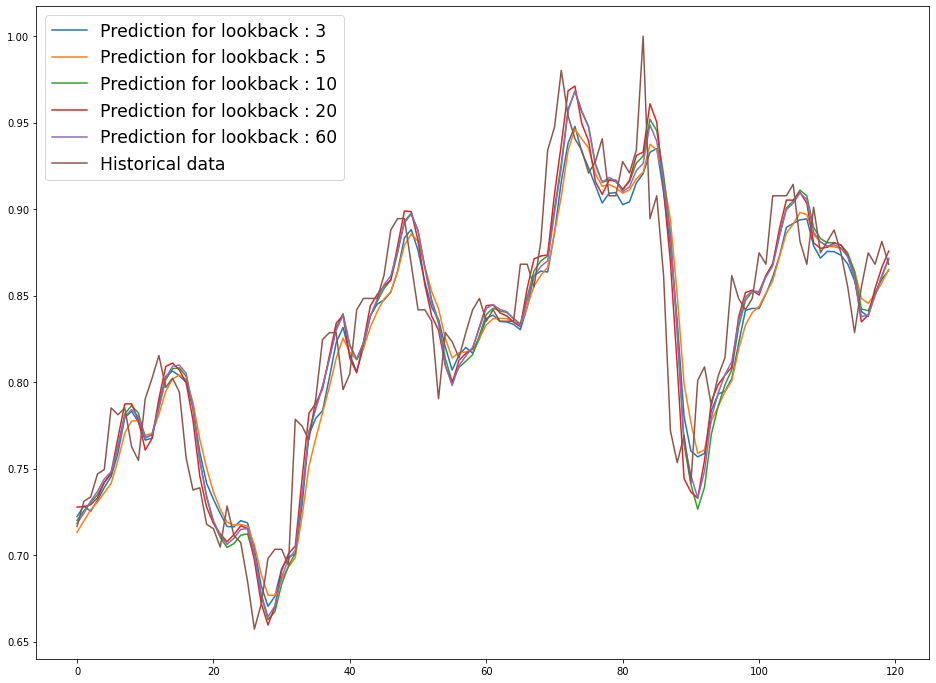

In [ ]:
lookbacks = [3, 5, 10 , 20, 60]

plt.figure(figsize=(16, 12))

for lookback in lookbacks:

  print(f'Training for lookback : {lookback} ')
  y_pred, y_test = allprocess(df, lookback, 5, 1, 500)
  plt.plot(y_pred.detach().numpy(), label=f'Prediction for lookback : {lookback}')
  print('-'*80)

plt.plot(y_test, label='Historical data')
plt.legend(fontsize='xx-large', loc='upper left')
plt.show()

In [ ]:
scaler = MinMaxScaler()
scaler_data = scaler.fit_transform(df.values)
scaler_data

array([[0.20767315, 0.19993969, 0.23157932, 0.20788645, 0.09550687],
       [0.22421068, 0.20839982, 0.23620318, 0.20887474, 0.10624357],
       [0.21800899, 0.19523945, 0.239671  , 0.2108514 , 0.06138845],
       ...,
       [0.7648988 , 0.69322233, 0.81518025, 0.69861634, 0.12710633],
       [0.74104793, 0.72111125, 0.82661238, 0.7540058 , 0.36821334],
       [0.79386061, 0.75364825, 0.86853021, 0.76378038, 0.51371425]])

In [ ]:
def split_data(stock, lookback):
    # data_raw = stock.to_numpy() # convert to numpy array
    data_raw = stock
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback,:])
    
    data = np.array(data);

    # print(data)
    # print(data.shape)

    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,3:4]
    
    x_test = data[train_set_size:,:-1,:]
    y_test = data[train_set_size:,-1,3:4]
    
    return [x_train, y_train, x_test, y_test]


lookback = 10 # choose sequence length
x_train, y_train, x_test, y_test = split_data(scaler_data, lookback)

In [ ]:
x_train.shape

(2244, 9, 5)

In [ ]:
x_test.shape

(561, 9, 5)

In [ ]:
y_train.shape

(2244, 1)

In [ ]:
y_test.shape

(561, 1)

In [ ]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
input_dim = 5
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.099239781498909
Epoch  1 MSE:  0.03253055363893509
Epoch  2 MSE:  0.0034379339776933193
Epoch  3 MSE:  0.035784076899290085
Epoch  4 MSE:  0.00879986397922039
Epoch  5 MSE:  0.003733804915100336
Epoch  6 MSE:  0.009750562720000744
Epoch  7 MSE:  0.013567294925451279
Epoch  8 MSE:  0.013193605467677116
Epoch  9 MSE:  0.010308009572327137
Epoch  10 MSE:  0.00679675443097949
Epoch  11 MSE:  0.004088299348950386
Epoch  12 MSE:  0.003004582365974784
Epoch  13 MSE:  0.0035791967529803514
Epoch  14 MSE:  0.004990044049918652
Epoch  15 MSE:  0.006016870029270649
Epoch  16 MSE:  0.0059319245629012585
Epoch  17 MSE:  0.004943248350173235
Epoch  18 MSE:  0.003776783123612404
Epoch  19 MSE:  0.003026751335710287
Epoch  20 MSE:  0.002872340613976121
Epoch  21 MSE:  0.003160151420161128
Epoch  22 MSE:  0.003605943638831377
Epoch  23 MSE:  0.003954359330236912
Epoch  24 MSE:  0.0040584891103208065
Epoch  25 MSE:  0.0038960345555096865
Epoch  26 MSE:  0.003546416526660323
Epoch  27 MS

In [ ]:
y_test_pred = model(x_test)

In [ ]:
len(y_test_pred)

561

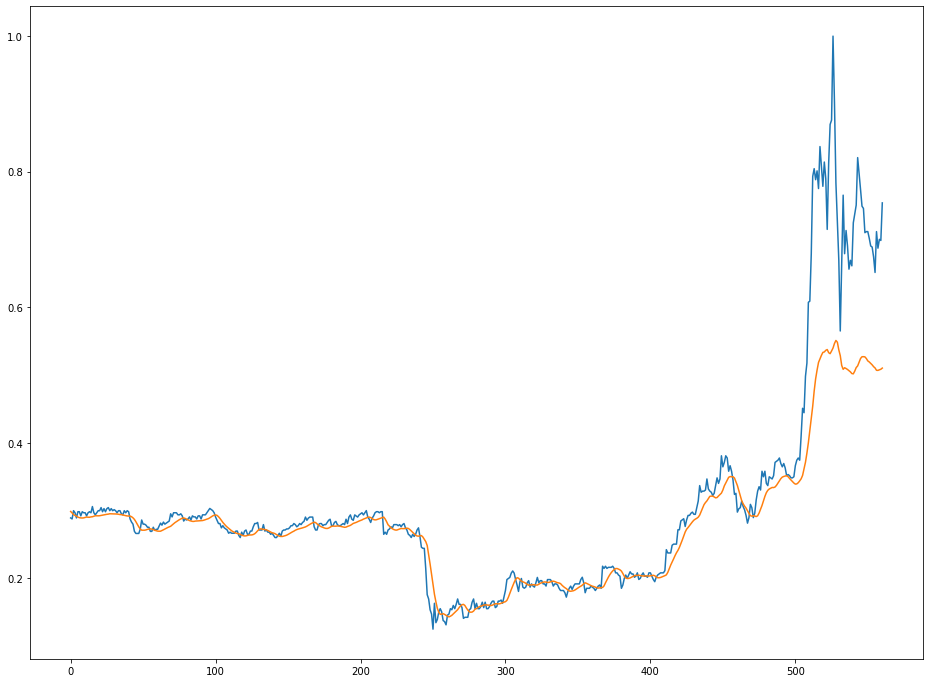

In [ ]:
plt.figure(figsize=(16, 12))

plt.plot(y_test_lstm.detach().numpy())
plt.plot(y_test_pred.detach().numpy())
plt.leg

plt.show()

In [ ]:
y_train_lstm

tensor([[0.0064],
        [0.0079],
        [0.0080],
        ...,
        [0.4500],
        [0.4521],
        [0.4529]])